# Imports

In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

from operator import itemgetter
from collections.abc import Iterable

import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

# Dataset Preparation

In [2]:
df = pd.read_csv("games/results.csv") 
df["date"] = pd.to_datetime(df["date"])
df = df[(df["date"] >= "2018-8-1")].reset_index(drop=True) # games at the 2022 wc cycle
df_wc = df # pre-wc outcomes

In [3]:
df_wc

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,2018-08-04,Belize,Barbados,1.0,0.0,Friendly,San Pedro,Belize,False
1,2018-08-04,Palestine,Iraq,0.0,3.0,Friendly,Al-Ram,Palestine,False
2,2018-08-15,Guatemala,Cuba,3.0,0.0,Friendly,Guatemala City,Guatemala,False
3,2018-08-18,Andorra,United Arab Emirates,0.0,0.0,Friendly,Grödig,Austria,True
4,2018-08-18,Grenada,Jamaica,1.0,5.0,Friendly,St. George's,Grenada,False
...,...,...,...,...,...,...,...,...,...
3903,2022-12-01,Canada,Morocco,NaN,NaN,FIFA World Cup,Doha,Qatar,True
3904,2022-12-02,Serbia,Switzerland,NaN,NaN,FIFA World Cup,Doha,Qatar,True
3905,2022-12-02,Cameroon,Brazil,NaN,NaN,FIFA World Cup,Lusail,Qatar,True
3906,2022-12-02,Ghana,Uruguay,NaN,NaN,FIFA World Cup,Al Wakrah,Qatar,True


In [4]:
rank = pd.read_csv("games/fifa_ranking-2022-10-06.csv")  # rankings
rank["rank_date"] = pd.to_datetime(rank["rank_date"]) 
rank = rank[(rank["rank_date"] >= "2018-8-1")].reset_index(drop=True)  # selecting games from the 2022 wc cycle
rank["country_full"] = (rank["country_full"]
                        .str.replace("IR Iran", "Iran")
                        .str.replace("Korea Republic", "South Korea")
                        .str.replace("USA", "United States")
                       )  # adjust names
rank = rank.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()
rank_wc = rank  # dataframe with rankings

In [5]:
rank_wc

,rank_date,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation
0,2018-08-16,145.0,Afghanistan,AFG,1068.00,1068.00,0.0,AFC
1,2018-08-17,145.0,Afghanistan,AFG,1068.00,1068.00,0.0,AFC
2,2018-08-18,145.0,Afghanistan,AFG,1068.00,1068.00,0.0,AFC
3,2018-08-19,145.0,Afghanistan,AFG,1068.00,1068.00,0.0,AFC
4,2018-08-20,145.0,Afghanistan,AFG,1068.00,1068.00,0.0,AFC
...,...,...,...,...,...,...,...,...
318894,2022-10-02,123.0,Zimbabwe,ZIM,1138.56,1138.56,0.0,CAF
318895,2022-10-03,123.0,Zimbabwe,ZIM,1138.56,1138.56,0.0,CAF
318896,2022-10-04,123.0,Zimbabwe,ZIM,1138.56,1138.56,0.0,CAF
318897,2022-10-05,123.0,Zimbabwe,ZIM,1138.56,1138.56,0.0,CAF


In [6]:
#  Merge dataframe
df_wc_ranked = df_wc.merge(
    rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]],
    left_on=["date", "home_team"], 
    right_on=["rank_date", "country_full"]
).drop(["rank_date", "country_full"], axis=1)

df_wc_ranked = df_wc_ranked.merge(
    rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]],
    left_on=["date", "away_team"],
    right_on=["rank_date", "country_full"],
    suffixes=("_home", "_away")
).drop(["rank_date", "country_full"], axis=1)

In [7]:
df_wc_ranked

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away
0,2018-08-18,Andorra,United Arab Emirates,0.0,0.0,Friendly,Grödig,Austria,True,1120.00,1120.00,130.0,0.0,1312.00,1312.00,77.0,0.0
1,2018-08-18,Grenada,Jamaica,1.0,5.0,Friendly,St. George's,Grenada,False,980.00,980.00,168.0,0.0,1400.00,1400.00,54.0,0.0
2,2018-08-18,Guatemala,Cuba,1.0,0.0,Friendly,Quetzaltenango,Guatemala,False,1064.00,1064.00,146.0,0.0,940.00,940.00,181.0,0.0
3,2018-08-20,Barbados,Jamaica,2.0,2.0,Friendly,Bridgetown,Barbados,False,1005.00,1008.00,160.0,0.0,1400.00,1400.00,54.0,0.0
4,2018-08-26,Barbados,Cuba,0.0,0.0,Friendly,Bridgetown,Barbados,False,1005.00,1008.00,160.0,0.0,940.00,940.00,181.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3331,2022-09-27,Norway,Serbia,0.0,2.0,UEFA Nations League,Oslo,Norway,False,1488.57,1488.57,36.0,0.0,1549.53,1549.53,25.0,0.0
3332,2022-09-27,Sweden,Slovenia,1.0,1.0,UEFA Nations League,Stockholm,Sweden,False,1563.44,1563.44,20.0,0.0,1372.48,1372.48,65.0,0.0
3333,2022-09-27,Kosovo,Cyprus,5.0,1.0,UEFA Nations League,Pristina,Kosovo,False,1183.90,1183.90,106.0,0.0,1180.52,1180.52,108.0,1.0
3334,2022-09-27,Greece,Northern Ireland,3.0,1.0,UEFA Nations League,Athens,Greece,False,1441.45,1441.45,49.0,1.0,1399.10,1399.10,58.0,0.0


# Feature Engineering

- Past game points made
- Past goals scored and suffered
- The importance of game (friendly or not)
- Rank of the teams
- Rank increasement of the teams
- Goals made and suffered by ranking faced

In [8]:
df = df_wc_ranked

In [9]:
def result_finder(home, away):
    if home > away:
        return pd.Series([0, 3, 0])    # 0: home team wins
    if home < away:
        return pd.Series([1, 0, 3])    # 1: away team wins
    else:
        return pd.Series([2, 1, 1])    # 2: draw

In [10]:
results = df.apply(lambda x: result_finder(x["home_score"], x["away_score"]), axis=1)

In [11]:
results

,0,1,2
0,2,1,1
1,1,0,3
2,0,3,0
3,2,1,1
4,2,1,1
...,...,...,...
3331,1,0,3
3332,2,1,1
3333,0,3,0
3334,0,3,0


In [12]:
df[["result", "home_team_points", "away_team_points"]] = results
df

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away,result,home_team_points,away_team_points
0,2018-08-18,Andorra,United Arab Emirates,0.0,0.0,Friendly,Grödig,Austria,True,1120.00,1120.00,130.0,0.0,1312.00,1312.00,77.0,0.0,2,1,1
1,2018-08-18,Grenada,Jamaica,1.0,5.0,Friendly,St. George's,Grenada,False,980.00,980.00,168.0,0.0,1400.00,1400.00,54.0,0.0,1,0,3
2,2018-08-18,Guatemala,Cuba,1.0,0.0,Friendly,Quetzaltenango,Guatemala,False,1064.00,1064.00,146.0,0.0,940.00,940.00,181.0,0.0,0,3,0
3,2018-08-20,Barbados,Jamaica,2.0,2.0,Friendly,Bridgetown,Barbados,False,1005.00,1008.00,160.0,0.0,1400.00,1400.00,54.0,0.0,2,1,1
4,2018-08-26,Barbados,Cuba,0.0,0.0,Friendly,Bridgetown,Barbados,False,1005.00,1008.00,160.0,0.0,940.00,940.00,181.0,0.0,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3331,2022-09-27,Norway,Serbia,0.0,2.0,UEFA Nations League,Oslo,Norway,False,1488.57,1488.57,36.0,0.0,1549.53,1549.53,25.0,0.0,1,0,3
3332,2022-09-27,Sweden,Slovenia,1.0,1.0,UEFA Nations League,Stockholm,Sweden,False,1563.44,1563.44,20.0,0.0,1372.48,1372.48,65.0,0.0,2,1,1
3333,2022-09-27,Kosovo,Cyprus,5.0,1.0,UEFA Nations League,Pristina,Kosovo,False,1183.90,1183.90,106.0,0.0,1180.52,1180.52,108.0,1.0,0,3,0
3334,2022-09-27,Greece,Northern Ireland,3.0,1.0,UEFA Nations League,Athens,Greece,False,1441.45,1441.45,49.0,1.0,1399.10,1399.10,58.0,0.0,0,3,0


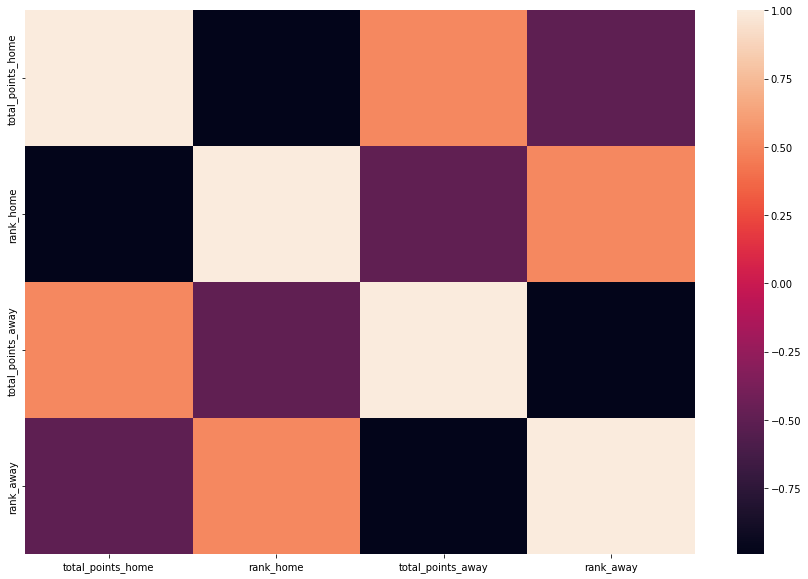

In [13]:
plt.figure(figsize=(15, 10))
sns.heatmap(df[["total_points_home", "rank_home", "total_points_away", "rank_away"]].corr())
plt.show();

In [14]:
df["rank_dif"] = df["rank_home"] - df["rank_away"]
df["sg"] = df["home_score"] - df["away_score"]
df["points_home_by_rank"] = df["home_team_points"]/df["rank_away"]
df["points_away_by_rank"] = df["away_team_points"]/df["rank_home"]

In [15]:
home_team = df[["date", "home_team", "home_score", "away_score", "rank_home",
                "rank_away", "rank_change_home", "total_points_home", "result",
                "rank_dif", "points_home_by_rank", "home_team_points"]]

away_team = df[["date", "away_team", "away_score", "home_score", "rank_away",
                "rank_home", "rank_change_away", "total_points_away", "result",
                "rank_dif", "points_away_by_rank", "away_team_points"]]

In [16]:
home_team.columns = [
    h.replace("home_", "").replace("_home", "").replace("away_", "suf_").replace("_away", "_suf")
    for h in home_team.columns
]

away_team.columns = [
    a.replace("away_", "").replace("_away", "").replace("home_", "suf_").replace("_home", "_suf")
    for a in away_team.columns
]

In [17]:
team_stats = home_team.append(away_team)#.sort_values("date")

C:\Users\johnw\AppData\Local\Temp\ipykernel_23572\275322566.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  team_stats = home_team.append(away_team)#.sort_values("date")


In [18]:
team_stats

,date,team,score,suf_score,rank,rank_suf,rank_change,total_points,result,rank_dif,points_by_rank,team_points
0,2018-08-18,Andorra,0.0,0.0,130.0,77.0,0.0,1120.00,2,53.0,0.012987,1
1,2018-08-18,Grenada,1.0,5.0,168.0,54.0,0.0,980.00,1,114.0,0.000000,0
2,2018-08-18,Guatemala,1.0,0.0,146.0,181.0,0.0,1064.00,0,-35.0,0.016575,3
3,2018-08-20,Barbados,2.0,2.0,160.0,54.0,0.0,1005.00,2,106.0,0.018519,1
4,2018-08-26,Barbados,0.0,0.0,160.0,181.0,0.0,1005.00,2,-21.0,0.005525,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3331,2022-09-27,Serbia,2.0,0.0,25.0,36.0,0.0,1549.53,1,11.0,0.083333,3
3332,2022-09-27,Slovenia,1.0,1.0,65.0,20.0,0.0,1372.48,2,-45.0,0.050000,1
3333,2022-09-27,Cyprus,1.0,5.0,108.0,106.0,1.0,1180.52,0,-2.0,0.000000,0
3334,2022-09-27,Northern Ireland,1.0,3.0,58.0,49.0,0.0,1399.10,0,-9.0,0.000000,0


In [19]:
# this column will be used to calculate features for simulation
team_stats_raw = team_stats.copy()

Now, we have a database ready to create predictive features. They will be:

- Mean goals of the team in World Cup Cycle.
- Mean goals of the team in last 5 games.
- Mean goals suffered of the team in World Cup Cycle.
- Mean goals suffered of the team in last 5 games.
- Mean FIFA Rank that team faced in World Cup Cycle.
- Mean FIFA Rank that team faced in last 5 games.
- FIFA Points won at the cycle.
- FIFA Points won in last 5 games.
- Mean game points at the Cycle.
- Mean game points at last 5 games.
- Mean game points by rank faced at the Cycle.
- Mean game points by rank faced at last 5 games.

In [20]:
stats_val = []

for index, row in team_stats.iterrows():
    team = row["team"]
    date = row["date"]
    past_games = (
        team_stats.loc[(team_stats["team"] == team) & (team_stats["date"] < date)]
        .sort_values(by=['date'], ascending=False)
    )
    last5 = past_games.head(5)
    
    goals = past_games["score"].mean()
    goals_l5 = last5["score"].mean()
    
    goals_suf = past_games["suf_score"].mean()
    goals_suf_l5 = last5["suf_score"].mean()
    
    rank = past_games["rank_suf"].mean()
    rank_l5 = last5["rank_suf"].mean()
    
    if len(last5) > 0:
        points = past_games["total_points"].values[0] - past_games["total_points"].values[-1]
        points_l5 = last5["total_points"].values[0] - last5["total_points"].values[-1] 
    else:
        points = 0
        points_l5 = 0
        
    gp = past_games["team_points"].mean()
    gp_l5 = last5["team_points"].mean()
    
    gp_rank = past_games["points_by_rank"].mean()
    gp_rank_l5 = last5["points_by_rank"].mean()
    
    stats_val.append([goals, goals_l5, goals_suf, goals_suf_l5, rank, rank_l5, points, points_l5, gp, gp_l5, gp_rank, gp_rank_l5])

In [21]:
stats_cols = ["goals_mean", "goals_mean_l5", "goals_suf_mean", "goals_suf_mean_l5",
              "rank_mean", "rank_mean_l5", "points_mean", "points_mean_l5", 
              "game_points_mean", "game_points_mean_l5", "game_points_rank_mean", 
              "game_points_rank_mean_l5"]

stats_df = pd.DataFrame(stats_val, columns=stats_cols)

In [22]:
stats_df

,goals_mean,goals_mean_l5,goals_suf_mean,goals_suf_mean_l5,rank_mean,rank_mean_l5,points_mean,points_mean_l5,game_points_mean,game_points_mean_l5,game_points_rank_mean,game_points_rank_mean_l5
0,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
4,2.000000,2.0,2.000000,2.0,54.000000,54.0,0.00,0.00,1.000000,1.0,0.018519,0.018519
...,...,...,...,...,...,...,...,...,...,...,...,...
6667,1.800000,2.2,1.111111,1.0,54.533333,42.0,90.53,2.00,1.866667,2.0,0.053327,0.073887
6668,1.380952,1.0,1.000000,1.8,76.357143,29.2,-19.52,-5.75,1.404762,1.0,0.026035,0.029545
6669,0.767442,0.6,1.767442,1.4,70.418605,63.8,-99.48,-5.57,0.767442,1.0,0.009687,0.019652
6670,1.023256,1.2,1.279070,1.4,57.906977,95.6,-92.90,-24.45,1.139535,1.0,0.022315,0.009470


In [23]:
full_df = pd.concat([team_stats.reset_index(drop=True), stats_df], axis=1, ignore_index=False)

In [24]:
full_df

,date,team,score,suf_score,rank,rank_suf,rank_change,total_points,result,rank_dif,...,goals_suf_mean,goals_suf_mean_l5,rank_mean,rank_mean_l5,points_mean,points_mean_l5,game_points_mean,game_points_mean_l5,game_points_rank_mean,game_points_rank_mean_l5
0,2018-08-18,Andorra,0.0,0.0,130.0,77.0,0.0,1120.00,2,53.0,...,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
1,2018-08-18,Grenada,1.0,5.0,168.0,54.0,0.0,980.00,1,114.0,...,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
2,2018-08-18,Guatemala,1.0,0.0,146.0,181.0,0.0,1064.00,0,-35.0,...,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
3,2018-08-20,Barbados,2.0,2.0,160.0,54.0,0.0,1005.00,2,106.0,...,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
4,2018-08-26,Barbados,0.0,0.0,160.0,181.0,0.0,1005.00,2,-21.0,...,2.000000,2.0,54.000000,54.0,0.00,0.00,1.000000,1.0,0.018519,0.018519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6667,2022-09-27,Serbia,2.0,0.0,25.0,36.0,0.0,1549.53,1,11.0,...,1.111111,1.0,54.533333,42.0,90.53,2.00,1.866667,2.0,0.053327,0.073887
6668,2022-09-27,Slovenia,1.0,1.0,65.0,20.0,0.0,1372.48,2,-45.0,...,1.000000,1.8,76.357143,29.2,-19.52,-5.75,1.404762,1.0,0.026035,0.029545
6669,2022-09-27,Cyprus,1.0,5.0,108.0,106.0,1.0,1180.52,0,-2.0,...,1.767442,1.4,70.418605,63.8,-99.48,-5.57,0.767442,1.0,0.009687,0.019652
6670,2022-09-27,Northern Ireland,1.0,3.0,58.0,49.0,0.0,1399.10,0,-9.0,...,1.279070,1.4,57.906977,95.6,-92.90,-24.45,1.139535,1.0,0.022315,0.009470


In [25]:
home_team_stats = full_df.iloc[:int(full_df.shape[0]/2),:]
away_team_stats = full_df.iloc[int(full_df.shape[0]/2):,:]

In [26]:
# New columns

home_team_stats.columns[-12:]

Index(['goals_mean', 'goals_mean_l5', 'goals_suf_mean', 'goals_suf_mean_l5',
       'rank_mean', 'rank_mean_l5', 'points_mean', 'points_mean_l5',
       'game_points_mean', 'game_points_mean_l5', 'game_points_rank_mean',
       'game_points_rank_mean_l5'],
      dtype='object')

In [27]:
home_team_stats = home_team_stats[home_team_stats.columns[-12:]]
away_team_stats = away_team_stats[away_team_stats.columns[-12:]]

In [28]:
home_team_stats.columns = ['home_'+str(col) for col in home_team_stats.columns]
away_team_stats.columns = ['away_'+str(col) for col in away_team_stats.columns]

In [29]:
match_stats = pd.concat(
    [home_team_stats, away_team_stats.reset_index(drop=True)], 
    axis=1, 
    ignore_index=False
)

In [30]:
match_stats

,home_goals_mean,home_goals_mean_l5,home_goals_suf_mean,home_goals_suf_mean_l5,home_rank_mean,home_rank_mean_l5,home_points_mean,home_points_mean_l5,home_game_points_mean,home_game_points_mean_l5,...,away_goals_suf_mean,away_goals_suf_mean_l5,away_rank_mean,away_rank_mean_l5,away_points_mean,away_points_mean_l5,away_game_points_mean,away_game_points_mean_l5,away_game_points_rank_mean,away_game_points_rank_mean_l5
0,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,...,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,...,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,...,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,...,1.000000,1.0,168.000000,168.0,0.00,0.00,3.000000,3.0,0.017857,0.017857
4,2.000000,2.0,2.000000,2.0,54.000000,54.0,0.00,0.00,1.000000,1.0,...,1.000000,1.0,146.000000,146.0,0.00,0.00,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3331,1.761905,1.4,0.880952,1.0,63.547619,38.6,82.57,25.07,1.833333,2.0,...,1.111111,1.0,54.533333,42.0,90.53,2.00,1.866667,2.0,0.053327,0.073887
3332,1.411765,1.2,1.137255,2.0,51.254902,39.4,-1.56,-21.33,1.607843,0.6,...,1.000000,1.8,76.357143,29.2,-19.52,-5.75,1.404762,1.0,0.026035,0.029545
3333,1.434783,1.2,1.304348,1.4,77.456522,65.4,103.90,10.00,1.326087,1.2,...,1.767442,1.4,70.418605,63.8,-99.48,-5.57,0.767442,1.0,0.009687,0.019652
3334,1.090909,1.4,0.909091,0.2,73.931818,96.2,5.45,20.02,1.590909,2.4,...,1.279070,1.4,57.906977,95.6,-92.90,-24.45,1.139535,1.0,0.022315,0.009470


In [31]:
full_df = pd.concat([df, match_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [32]:
full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'result', 'home_team_points', 'away_team_points',
       'rank_dif', 'sg', 'points_home_by_rank', 'points_away_by_rank',
       'home_goals_mean', 'home_goals_mean_l5', 'home_goals_suf_mean',
       'home_goals_suf_mean_l5', 'home_rank_mean', 'home_rank_mean_l5',
       'home_points_mean', 'home_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5', 'away_goals_mean',
       'away_goals_mean_l5', 'away_goals_suf_mean', 'away_goals_suf_mean_l5',
       'away_rank_mean', 'away_rank_mean_l5', 'away_points_mean',
       'away_points_mean_l5', 'away_game_points_mean',
       'away_game_points_mean_l5', 'away_

In [33]:
def find_friendly(x):
    if x == "Friendly":
        return 1
    else: return 0

In [34]:
full_df["is_friendly"] = full_df["tournament"].apply(lambda x: find_friendly(x))

In [35]:
full_df = pd.get_dummies(full_df, columns=["is_friendly"])

In [36]:
full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'result', 'home_team_points', 'away_team_points',
       'rank_dif', 'sg', 'points_home_by_rank', 'points_away_by_rank',
       'home_goals_mean', 'home_goals_mean_l5', 'home_goals_suf_mean',
       'home_goals_suf_mean_l5', 'home_rank_mean', 'home_rank_mean_l5',
       'home_points_mean', 'home_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5', 'away_goals_mean',
       'away_goals_mean_l5', 'away_goals_suf_mean', 'away_goals_suf_mean_l5',
       'away_rank_mean', 'away_rank_mean_l5', 'away_points_mean',
       'away_points_mean_l5', 'away_game_points_mean',
       'away_game_points_mean_l5', 'away_

In [37]:
# select only columns that will help in Features' analysis

base_df = full_df[["date", "home_team", "away_team", "rank_home", "rank_away",
                   "home_score", "away_score", "result", "rank_dif", "rank_change_home", 
                   "rank_change_away", 'home_goals_mean', 'home_goals_mean_l5',
                   'home_goals_suf_mean', 'home_goals_suf_mean_l5', 'home_rank_mean',
                   'home_rank_mean_l5', 'home_points_mean', 'home_points_mean_l5',
                   'away_goals_mean', 'away_goals_mean_l5', 'away_goals_suf_mean',
                   'away_goals_suf_mean_l5', 'away_rank_mean', 'away_rank_mean_l5',
                   'away_points_mean', 'away_points_mean_l5', 'home_game_points_mean',
                   'home_game_points_mean_l5', 'home_game_points_rank_mean',
                   'home_game_points_rank_mean_l5', 'away_game_points_mean',
                   'away_game_points_mean_l5', 'away_game_points_rank_mean',
                   'away_game_points_rank_mean_l5', 'is_friendly_0', 'is_friendly_1']]

In [38]:
base_df

,date,home_team,away_team,rank_home,rank_away,home_score,away_score,result,rank_dif,rank_change_home,...,home_game_points_mean,home_game_points_mean_l5,home_game_points_rank_mean,home_game_points_rank_mean_l5,away_game_points_mean,away_game_points_mean_l5,away_game_points_rank_mean,away_game_points_rank_mean_l5,is_friendly_0,is_friendly_1
0,2018-08-18,Andorra,United Arab Emirates,130.0,77.0,0.0,0.0,2,53.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
1,2018-08-18,Grenada,Jamaica,168.0,54.0,1.0,5.0,1,114.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
2,2018-08-18,Guatemala,Cuba,146.0,181.0,1.0,0.0,0,-35.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
3,2018-08-20,Barbados,Jamaica,160.0,54.0,2.0,2.0,2,106.0,0.0,...,NaN,NaN,NaN,NaN,3.000000,3.0,0.017857,0.017857,0,1
4,2018-08-26,Barbados,Cuba,160.0,181.0,0.0,0.0,2,-21.0,0.0,...,1.000000,1.0,0.018519,0.018519,0.000000,0.0,0.000000,0.000000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3331,2022-09-27,Norway,Serbia,36.0,25.0,0.0,2.0,1,11.0,0.0,...,1.833333,2.0,0.041984,0.090235,1.866667,2.0,0.053327,0.073887,1,0
3332,2022-09-27,Sweden,Slovenia,20.0,65.0,1.0,1.0,2,-45.0,0.0,...,1.607843,0.6,0.048520,0.009231,1.404762,1.0,0.026035,0.029545,1,0
3333,2022-09-27,Kosovo,Cyprus,106.0,108.0,5.0,1.0,0,-2.0,0.0,...,1.326087,1.2,0.018478,0.016825,0.767442,1.0,0.009687,0.019652,1,0
3334,2022-09-27,Greece,Northern Ireland,49.0,58.0,3.0,1.0,0,-9.0,1.0,...,1.590909,2.4,0.050090,0.028040,1.139535,1.0,0.022315,0.009470,1,0


In [39]:
base_df.isna().sum()

date                               0
home_team                          0
away_team                          0
rank_home                          0
rank_away                          0
home_score                         0
away_score                         0
result                             0
rank_dif                           0
rank_change_home                   0
rank_change_away                   0
home_goals_mean                  101
home_goals_mean_l5               101
home_goals_suf_mean              101
home_goals_suf_mean_l5           101
home_rank_mean                   101
home_rank_mean_l5                101
home_points_mean                   0
home_points_mean_l5                0
away_goals_mean                  100
away_goals_mean_l5               100
away_goals_suf_mean              100
away_goals_suf_mean_l5           100
away_rank_mean                   100
away_rank_mean_l5                100
away_points_mean                   0
away_points_mean_l5                0
h

In [40]:
base_df_no_fg = base_df.dropna()

# Data Analysis

In [41]:
df = base_df_no_fg

In [42]:
def no_draw(x):
    if x == 2:
        return 1
    else:
        return x

In [43]:
df["target"] = df["result"].apply(lambda x: no_draw(x))

C:\Users\johnw\AppData\Local\Temp\ipykernel_23572\1055459299.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["target"] = df["result"].apply(lambda x: no_draw(x))


In [44]:
data1 = df[list(df.columns[8:20].values) + ["target"]]
data2 = df[df.columns[20:]]

In [45]:
data1

,rank_dif,rank_change_home,rank_change_away,home_goals_mean,home_goals_mean_l5,home_goals_suf_mean,home_goals_suf_mean_l5,home_rank_mean,home_rank_mean_l5,home_points_mean,home_points_mean_l5,away_goals_mean,target
4,-21.0,0.0,0.0,2.000000,2.0,2.000000,2.0,54.000000,54.0,0.00,0.00,0.000000,1
6,-21.0,0.0,0.0,1.000000,1.0,1.000000,1.0,117.500000,117.5,0.00,0.00,0.000000,1
31,-4.0,0.0,0.0,4.000000,4.0,1.000000,1.0,185.000000,185.0,0.00,0.00,0.000000,1
32,-22.0,0.0,0.0,1.000000,1.0,2.000000,2.0,201.000000,201.0,0.00,0.00,0.000000,0
33,-7.0,0.0,0.0,1.000000,1.0,0.500000,0.5,191.500000,191.5,0.00,0.00,2.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3331,11.0,0.0,0.0,1.761905,1.4,0.880952,1.0,63.547619,38.6,82.57,25.07,1.800000,1
3332,-45.0,0.0,0.0,1.411765,1.2,1.137255,2.0,51.254902,39.4,-1.56,-21.33,1.380952,1
3333,-2.0,0.0,1.0,1.434783,1.2,1.304348,1.4,77.456522,65.4,103.90,10.00,0.767442,0
3334,-9.0,1.0,0.0,1.090909,1.4,0.909091,0.2,73.931818,96.2,5.45,20.02,1.023256,0


In [46]:
data2

,away_goals_mean_l5,away_goals_suf_mean,away_goals_suf_mean_l5,away_rank_mean,away_rank_mean_l5,away_points_mean,away_points_mean_l5,home_game_points_mean,home_game_points_mean_l5,home_game_points_rank_mean,home_game_points_rank_mean_l5,away_game_points_mean,away_game_points_mean_l5,away_game_points_rank_mean,away_game_points_rank_mean_l5,is_friendly_0,is_friendly_1,target
4,0.0,1.000000,1.0,146.000000,146.0,0.00,0.00,1.000000,1.0,0.018519,0.018519,0.000000,0.0,0.000000,0.000000,0,1,1
6,0.0,0.500000,0.5,153.000000,153.0,0.00,0.00,1.000000,1.0,0.012022,0.012022,0.500000,0.5,0.003125,0.003125,0,1,1
31,0.0,2.000000,2.0,185.000000,185.0,0.00,0.00,3.000000,3.0,0.016216,0.016216,0.000000,0.0,0.000000,0.000000,1,0,1
32,0.0,2.000000,2.0,194.000000,194.0,0.00,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1,0,0
33,2.0,1.000000,1.0,161.000000,161.0,0.00,0.00,1.500000,1.5,0.008197,0.008197,3.000000,3.0,0.018634,0.018634,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3331,2.2,1.111111,1.0,54.533333,42.0,90.53,2.00,1.833333,2.0,0.041984,0.090235,1.866667,2.0,0.053327,0.073887,1,0,1
3332,1.0,1.000000,1.8,76.357143,29.2,-19.52,-5.75,1.607843,0.6,0.048520,0.009231,1.404762,1.0,0.026035,0.029545,1,0,1
3333,0.6,1.767442,1.4,70.418605,63.8,-99.48,-5.57,1.326087,1.2,0.018478,0.016825,0.767442,1.0,0.009687,0.019652,1,0,0
3334,1.2,1.279070,1.4,57.906977,95.6,-92.90,-24.45,1.590909,2.4,0.050090,0.028040,1.139535,1.0,0.022315,0.009470,1,0,0


In [47]:
scaled = (data1[:-1] - data1[:-1].mean()) / data1[:-1].std()
scaled["target"] = data1["target"]
violin1 = pd.melt(scaled, id_vars="target", var_name="features", value_name="value")

scaled = (data2[:-1] - data2[:-1].mean()) / data2[:-1].std()
scaled["target"] = data2["target"]
violin2 = pd.melt(scaled, id_vars="target", var_name="features", value_name="value")

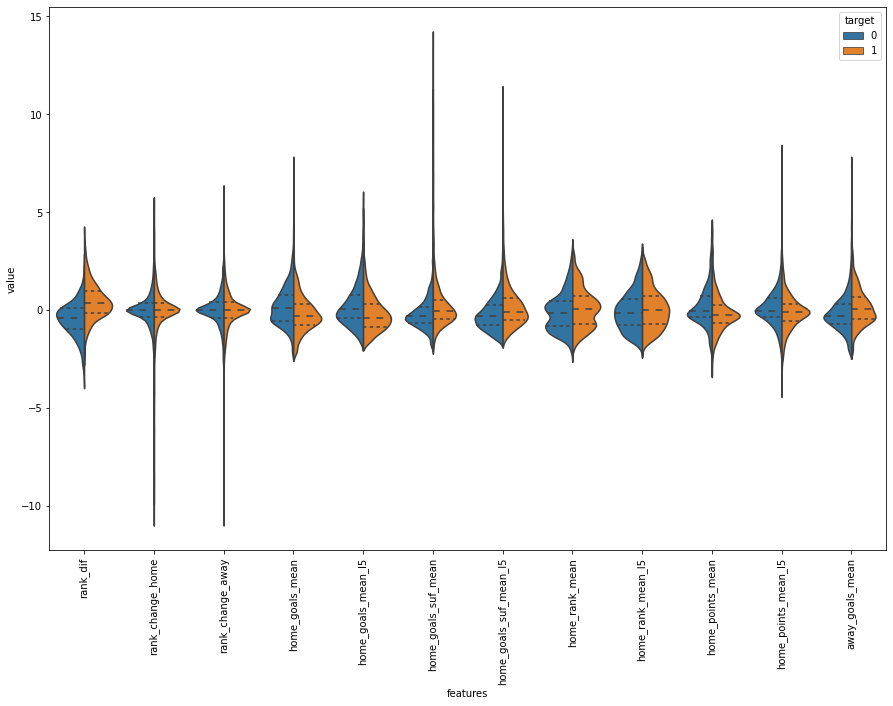

In [48]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin1, split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

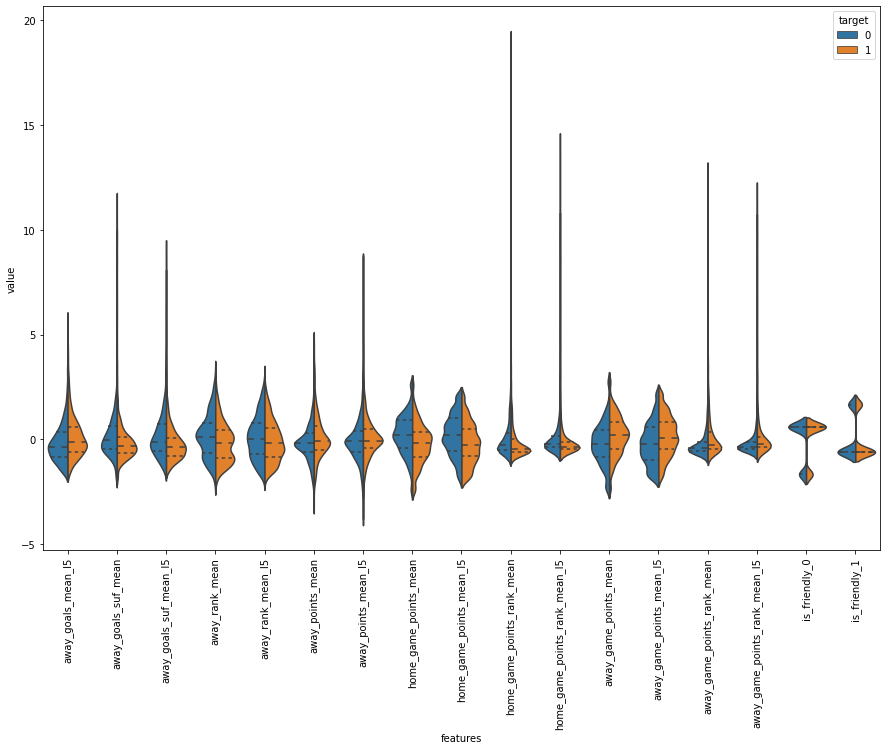

In [49]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin2, split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

In [50]:
dif = df.copy()
dif.loc[:, "goals_dif"] = dif["home_goals_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_mean_l5"]
dif.loc[:, "goals_suf_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_suf_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_made_suf_dif"] = dif["home_goals_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_made_suf_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_suf_made_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_suf_made_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_mean_l5"]

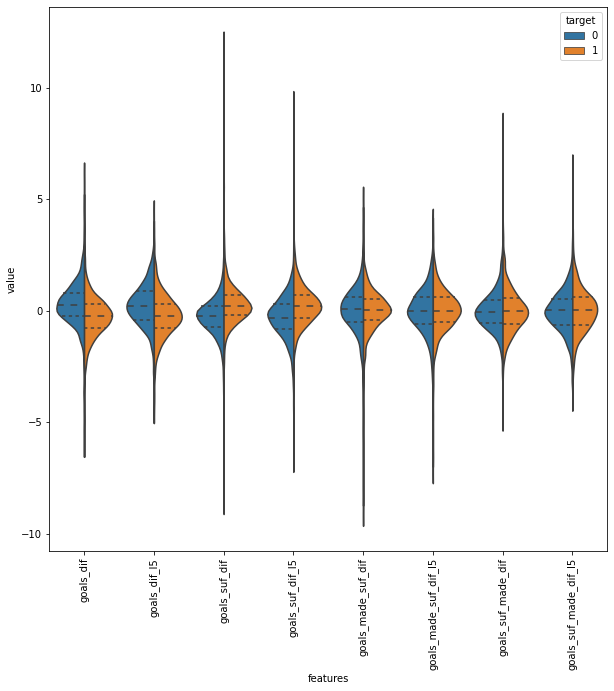

In [51]:
data_difs = dif.iloc[:, -8:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled, id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

In [52]:
dif.loc[:, "dif_points"] = dif["home_game_points_mean"] - dif["away_game_points_mean"]
dif.loc[:, "dif_points_l5"] = dif["home_game_points_mean_l5"] - dif["away_game_points_mean_l5"]
dif.loc[:, "dif_points_rank"] = dif["home_game_points_rank_mean"] - dif["away_game_points_rank_mean"]
dif.loc[:, "dif_points_rank_l5"] = dif["home_game_points_rank_mean_l5"] - dif["away_game_points_rank_mean_l5"]

In [53]:
dif.loc[:, "dif_rank_agst"] = dif["home_rank_mean"] - dif["away_rank_mean"]
dif.loc[:, "dif_rank_agst_l5"] = dif["home_rank_mean_l5"] - dif["away_rank_mean_l5"]

In [54]:
dif.loc[:, "goals_per_ranking_dif"] = (
    (dif["home_goals_mean"] / dif["home_rank_mean"]) - (dif["away_goals_mean"] / dif["away_rank_mean"])
)
dif.loc[:, "goals_per_ranking_suf_dif"] = (
    (dif["home_goals_suf_mean"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean"] / dif["away_rank_mean"])
)
dif.loc[:, "goals_per_ranking_dif_l5"] = (
    (dif["home_goals_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_mean_l5"] / dif["away_rank_mean"])
)
dif.loc[:, "goals_per_ranking_suf_dif_l5"] = (
    (dif["home_goals_suf_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean_l5"] / dif["away_rank_mean"])
)

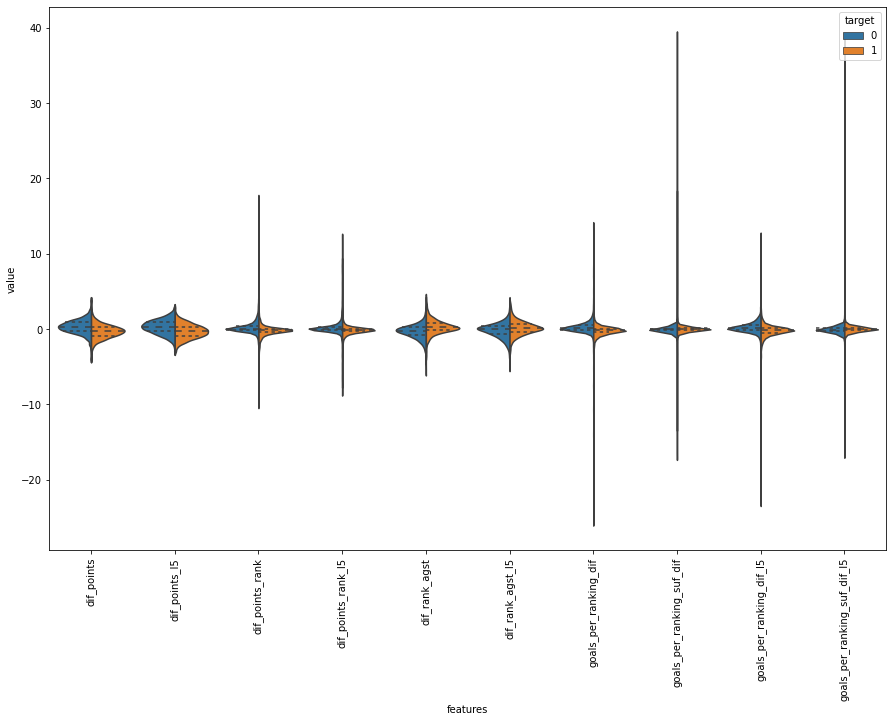

In [55]:
data_difs = dif.iloc[:, -10:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

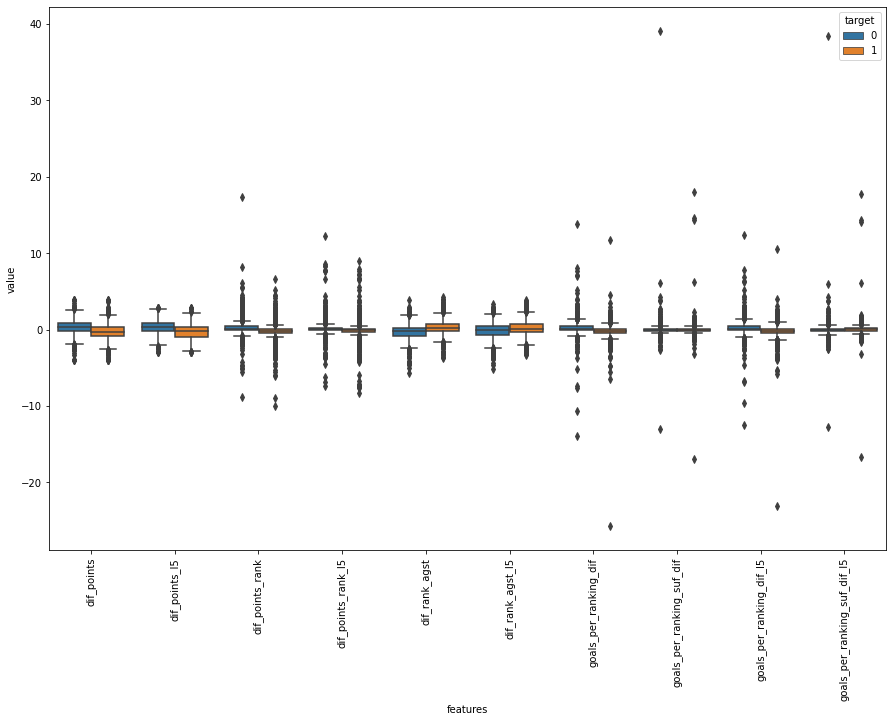

In [56]:
plt.figure(figsize=(15,10))
sns.boxplot(x="features", y="value", hue="target", data=violin)
plt.xticks(rotation=90)
plt.show()

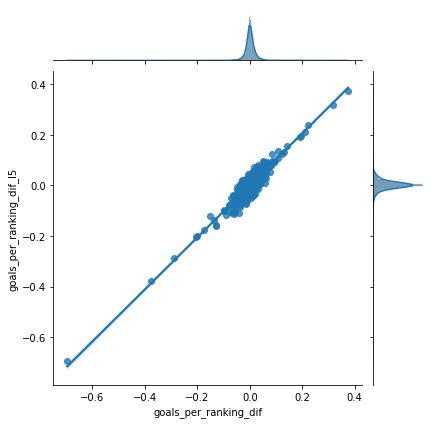

In [57]:
sns.jointplot(data = data_difs, x = 'goals_per_ranking_dif', y = 'goals_per_ranking_dif_l5', kind="reg")
plt.show()

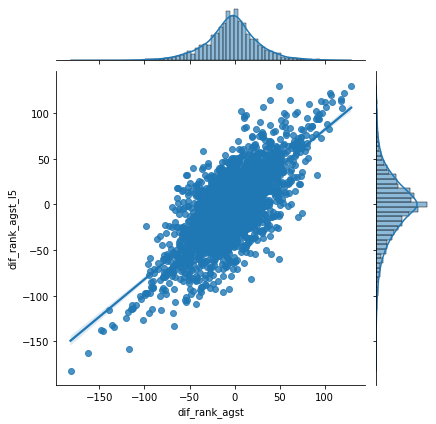

In [58]:
sns.jointplot(data = data_difs, x = 'dif_rank_agst', y = 'dif_rank_agst_l5', kind="reg")
plt.show()

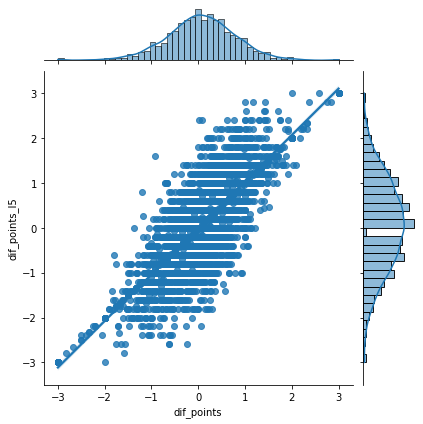

In [59]:
sns.jointplot(data = data_difs, x = 'dif_points', y = 'dif_points_l5', kind="reg")
plt.show()

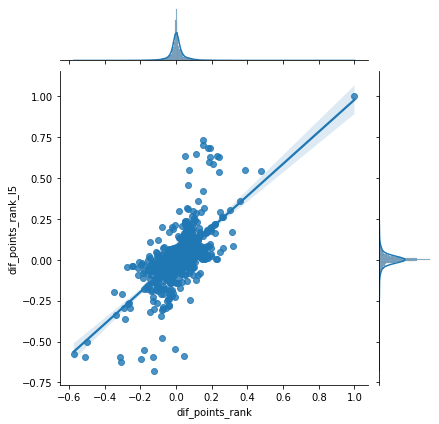

In [60]:
sns.jointplot(data = data_difs, x = 'dif_points_rank', y = 'dif_points_rank_l5', kind="reg")
plt.show()

Based on that, final features are:

- rank_dif
- goals_dif
- goals_dif_l5
- goals_suf_dif
- goals_suf_dif_l5
- dif_rank_agst
- dif_rank_agst_l5
- goals_per_ranking_dif
- dif_points_rank
- dif_points_rank_l5
- is_friendly

In [61]:
def create_db(df):
    columns = ["home_team", "away_team", "target", "rank_dif", "home_goals_mean",
               "home_rank_mean", "away_goals_mean", "away_rank_mean", "home_rank_mean_l5",
               "away_rank_mean_l5", "home_goals_suf_mean", "away_goals_suf_mean",
               "home_goals_mean_l5", "away_goals_mean_l5", "home_goals_suf_mean_l5",
               "away_goals_suf_mean_l5", "home_game_points_rank_mean",
               "home_game_points_rank_mean_l5", "away_game_points_rank_mean",
               "away_game_points_rank_mean_l5", "is_friendly_0", "is_friendly_1"]
    
    base = df.loc[:, columns]
    base.loc[:, "goals_dif"] = base["home_goals_mean"] - base["away_goals_mean"]
    base.loc[:, "goals_dif_l5"] = base["home_goals_mean_l5"] - base["away_goals_mean_l5"]
    base.loc[:, "goals_suf_dif"] = base["home_goals_suf_mean"] - base["away_goals_suf_mean"]
    base.loc[:, "goals_suf_dif_l5"] = base["home_goals_suf_mean_l5"] - base["away_goals_suf_mean_l5"]
    base.loc[:, "goals_per_ranking_dif"] = (
        (base["home_goals_mean"] / base["home_rank_mean"]) - (base["away_goals_mean"] / base["away_rank_mean"])
    )
    base.loc[:, "dif_rank_agst"] = base["home_rank_mean"] - base["away_rank_mean"]
    base.loc[:, "dif_rank_agst_l5"] = base["home_rank_mean_l5"] - base["away_rank_mean_l5"]
    base.loc[:, "dif_points_rank"] = base["home_game_points_rank_mean"] - base["away_game_points_rank_mean"]
    base.loc[:, "dif_points_rank_l5"] = base["home_game_points_rank_mean_l5"] - base["away_game_points_rank_mean_l5"]
    
    model_df = base[["home_team", "away_team", "target", "rank_dif", "goals_dif", "goals_dif_l5",
                     "goals_suf_dif", "goals_suf_dif_l5", "goals_per_ranking_dif", "dif_rank_agst",
                     "dif_rank_agst_l5", "dif_points_rank", "dif_points_rank_l5", "is_friendly_0", "is_friendly_1"]]
    return model_df

In [62]:
model_db = create_db(df)

In [63]:
model_db

,home_team,away_team,target,rank_dif,goals_dif,goals_dif_l5,goals_suf_dif,goals_suf_dif_l5,goals_per_ranking_dif,dif_rank_agst,dif_rank_agst_l5,dif_points_rank,dif_points_rank_l5,is_friendly_0,is_friendly_1
4,Barbados,Cuba,1,-21.0,2.000000,2.0,1.000000,1.0,0.037037,-92.000000,-92.0,0.018519,0.018519,0,1
6,Barbados,Cuba,1,-21.0,1.000000,1.0,0.500000,0.5,0.008511,-35.500000,-35.5,0.008897,0.008897,0,1
31,Mongolia,Guam,1,-4.0,4.000000,4.0,-1.000000,-1.0,0.021622,0.000000,0.0,0.016216,0.016216,1,0
32,Nepal,Bhutan,0,-22.0,1.000000,1.0,0.000000,0.0,0.004975,7.000000,7.0,0.000000,0.000000,1,0
33,Bangladesh,Pakistan,0,-7.0,-1.000000,-1.0,-0.500000,-0.5,-0.007200,30.500000,30.5,-0.010437,-0.010437,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3331,Norway,Serbia,1,11.0,-0.038095,-0.8,-0.230159,0.0,-0.005282,9.014286,-3.4,-0.011343,0.016348,1,0
3332,Sweden,Slovenia,1,-45.0,0.030812,0.2,0.137255,0.2,0.009459,-25.102241,10.2,0.022485,-0.020314,1,0
3333,Kosovo,Cyprus,0,-2.0,0.667341,0.6,-0.463094,0.0,0.007625,7.037917,1.6,0.008791,-0.002827,1,0
3334,Greece,Northern Ireland,0,-9.0,0.067653,0.2,-0.369979,-1.2,-0.002915,16.024841,0.6,0.027775,0.018570,1,0


# Modeling

In [64]:
X = model_db.iloc[:, 3:]
y = model_db[["target"]]

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1)

In [66]:
gb = GradientBoostingClassifier(random_state=5)

params = {"learning_rate": [0.01, 0.1, 0.5],
          "min_samples_split": [5, 10],
          "min_samples_leaf": [3, 5],
          "max_depth": [3, 5, 10],
          "max_features": ["sqrt"],
          "n_estimators": [100, 200]
         } 

gb_cv = GridSearchCV(gb, params, cv=3, n_jobs=-1, verbose=False)

gb_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=5),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 5, 10], 'max_features': ['sqrt'],
                         'min_samples_leaf': [3, 5],
                         'min_samples_split': [5, 10],
                         'n_estimators': [100, 200]},
             verbose=False)

In [67]:
gb = gb_cv.best_estimator_

In [68]:
gb

GradientBoostingClassifier(max_features='sqrt', min_samples_leaf=5,
                           min_samples_split=5, random_state=5)

In [69]:
gb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'n_estimators': 100}

In [70]:
params_rf = {"max_depth": [20],
             "min_samples_split": [10],
             "max_leaf_nodes": [175],
             "min_samples_leaf": [5],
             "n_estimators": [250],
             "max_features": ["sqrt"],
                }

rf = RandomForestClassifier(random_state=1)

rf_cv = GridSearchCV(rf, params_rf, cv=3, n_jobs=-1, verbose=False)

rf_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [20], 'max_features': ['sqrt'],
                         'max_leaf_nodes': [175], 'min_samples_leaf': [5],
                         'min_samples_split': [10], 'n_estimators': [250]},
             verbose=False)

In [71]:
rf = rf_cv.best_estimator_

In [72]:
rf

RandomForestClassifier(max_depth=20, max_features='sqrt', max_leaf_nodes=175,
                       min_samples_leaf=5, min_samples_split=10,
                       n_estimators=250, random_state=1)

In [73]:
def analyze(model):
    fpr, tpr, _ = roc_curve(
        y_test,
        model.predict_proba(X_test.values)[:, 1]
    )  #test AUC
    
    plt.figure(figsize=(15, 10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label="test")

    fpr_train, tpr_train, _ = roc_curve(
        y_train, 
        model.predict_proba(X_train.values)[:, 1]
    )  #train AUC
    
    plt.plot(fpr_train, tpr_train, label="train")
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test.values)[:, 1])
    auc_train = roc_auc_score(y_train, model.predict_proba(X_train.values)[:, 1])
    plt.legend()
    plt.title('AUC score is %.2f on test and %.2f on training' % (auc_test, auc_train))
    plt.show()
    
    plt.figure(figsize=(15, 10))
    cm = confusion_matrix(y_test, model.predict(X_test.values))
    sns.heatmap(cm, annot=True, fmt="d")

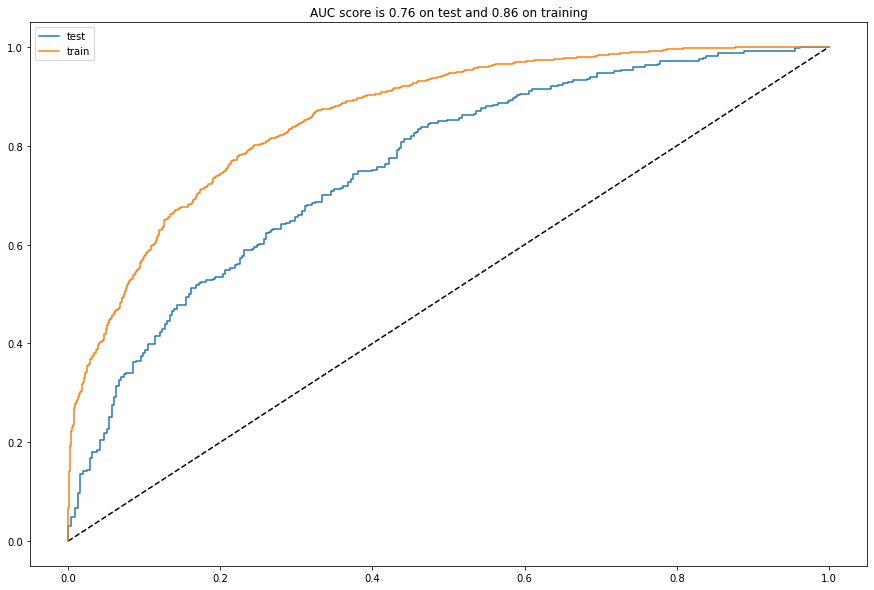

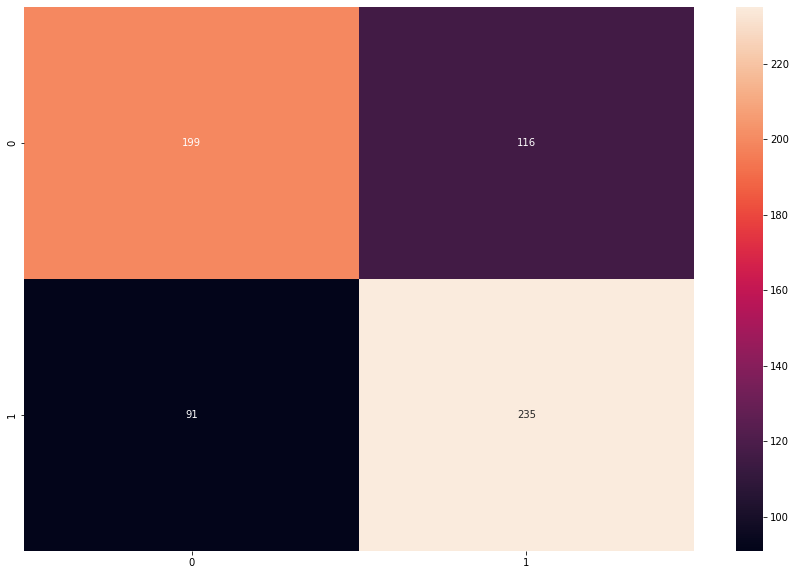

In [74]:
analyze(gb)

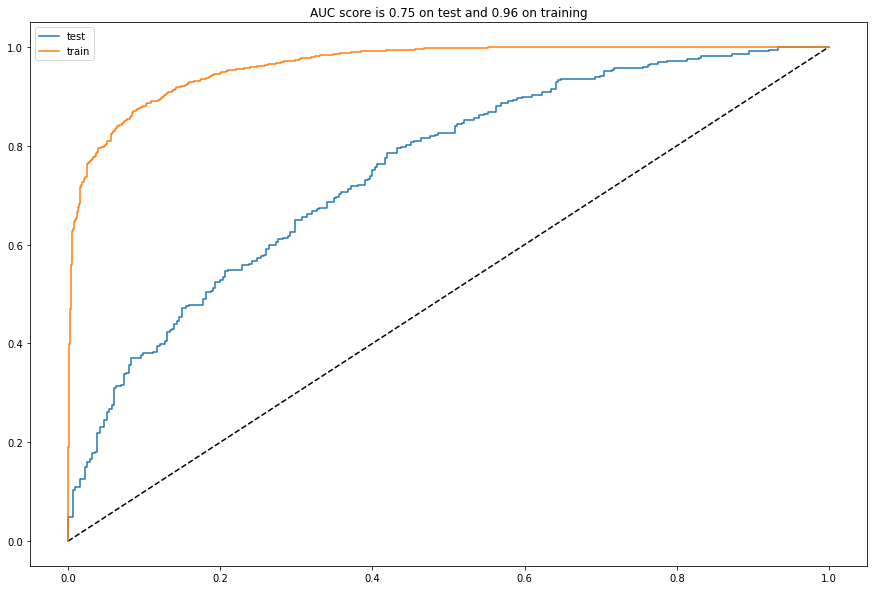

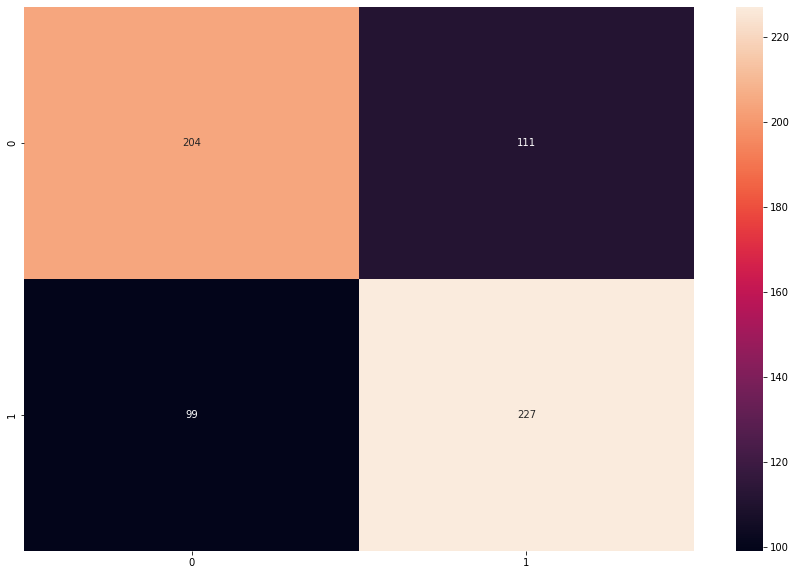

In [75]:
analyze(rf)

# World Cup Simulation

In [76]:
dfs = pd.read_html(r"https://en.wikipedia.org/wiki/2022_FIFA_World_Cup#Teams")

In [77]:
for i in range(len(dfs)):
    df = dfs[i]
    cols = list(df.columns.values)
    
    if isinstance(cols[0], Iterable):
        if any("Tie-breaking criteria" in c for c in cols):
            start_pos = i+1

        if any("Match 46" in c for c in cols):
            end_pos = i+1

In [78]:
matches = []
groups = ["A", "B", "C", "D", "E", "F", "G", "H"]
group_count = 0 

table = {}

# TABLE -> TEAM, POINTS, WIN PROBS (CRITERIO DE DESEMPATE)
table[groups[group_count]] = [[a.split(" ")[0], 0, []] for a in list(dfs[start_pos].iloc[:, 1].values)]

for i in range(start_pos+1, end_pos, 1):
    if len(dfs[i].columns) == 3:
        team_1 = dfs[i].columns.values[0]
        team_2 = dfs[i].columns.values[-1]
        
        matches.append((groups[group_count], team_1, team_2))
    else:
        group_count += 1
        table[groups[group_count]] = [[a, 0, []] for a in list(dfs[i].iloc[:, 1].values)]

In [79]:
table

{'A': [['Netherlands', 0, []],
  ['Ecuador', 0, []],
  ['Senegal', 0, []],
  ['Qatar', 0, []]],
 'B': [['England', 0, []],
  ['Iran', 0, []],
  ['United States', 0, []],
  ['Wales', 0, []]],
 'C': [['Saudi Arabia', 0, []],
  ['Poland', 0, []],
  ['Mexico', 0, []],
  ['Argentina', 0, []]],
 'D': [['France', 0, []],
  ['Tunisia', 0, []],
  ['Denmark', 0, []],
  ['Australia', 0, []]],
 'E': [['Spain', 0, []],
  ['Japan', 0, []],
  ['Germany', 0, []],
  ['Costa Rica', 0, []]],
 'F': [['Belgium', 0, []],
  ['Croatia', 0, []],
  ['Morocco', 0, []],
  ['Canada', 0, []]],
 'G': [['Brazil', 0, []],
  ['Switzerland', 0, []],
  ['Cameroon', 0, []],
  ['Serbia', 0, []]],
 'H': [['Portugal', 0, []],
  ['South Korea', 0, []],
  ['Uruguay', 0, []],
  ['Ghana', 0, []]]}

In [80]:
matches[:10]

[('A', 'Qatar', 'Ecuador'),
 ('A', 'Senegal', 'Netherlands'),
 ('A', 'Qatar', 'Senegal'),
 ('A', 'Netherlands', 'Ecuador'),
 ('A', 'Ecuador', 'Senegal'),
 ('A', 'Netherlands', 'Qatar'),
 ('B', 'England', 'Iran'),
 ('B', 'United States', 'Wales'),
 ('B', 'Wales', 'Iran'),
 ('B', 'England', 'United States')]

In [81]:
def find_stats(team_1):
#team_1 = "Qatar"
    past_games = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date")
    last5 = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date").tail(5)

    team_1_rank = past_games["rank"].values[-1]
    team_1_goals = past_games.score.mean()
    team_1_goals_l5 = last5.score.mean()
    team_1_goals_suf = past_games.suf_score.mean()
    team_1_goals_suf_l5 = last5.suf_score.mean()
    team_1_rank_suf = past_games.rank_suf.mean()
    team_1_rank_suf_l5 = last5.rank_suf.mean()
    team_1_gp_rank = past_games.points_by_rank.mean()
    team_1_gp_rank_l5 = last5.points_by_rank.mean()

    return [team_1_rank, team_1_goals, team_1_goals_l5, team_1_goals_suf, team_1_goals_suf_l5, team_1_rank_suf, team_1_rank_suf_l5, team_1_gp_rank, team_1_gp_rank_l5]

In [82]:
def find_features(team_1, team_2):
    rank_dif = team_1[0] - team_2[0]
    goals_dif = team_1[1] - team_2[1]
    goals_dif_l5 = team_1[2] - team_2[2]
    goals_suf_dif = team_1[3] - team_2[3]
    goals_suf_dif_l5 = team_1[4] - team_2[4]
    goals_per_ranking_dif = (team_1[1]/team_1[5]) - (team_2[1]/team_2[5])
    dif_rank_agst = team_1[5] - team_2[5]
    dif_rank_agst_l5 = team_1[6] - team_2[6]
    dif_gp_rank = team_1[7] - team_2[7]
    dif_gp_rank_l5 = team_1[8] - team_2[8]
    
    return [rank_dif, goals_dif, goals_dif_l5, goals_suf_dif, goals_suf_dif_l5, goals_per_ranking_dif, dif_rank_agst, dif_rank_agst_l5, dif_gp_rank, dif_gp_rank_l5, 1, 0]

In [83]:
advanced_group = []
last_group = ""

for k in table.keys():
    for t in table[k]:
        t[1] = 0
        t[2] = []
        
for teams in matches:
    draw = False
    team_1 = find_stats(teams[1])
    team_2 = find_stats(teams[2])

    

    features_g1 = find_features(team_1, team_2)
    features_g2 = find_features(team_2, team_1)

    probs_g1 = gb.predict_proba([features_g1])
    probs_g2 = gb.predict_proba([features_g2])
    
    team_1_prob_g1 = probs_g1[0][0]
    team_1_prob_g2 = probs_g2[0][1]
    team_2_prob_g1 = probs_g1[0][1]
    team_2_prob_g2 = probs_g2[0][0]

    team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
    team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
    
    if ((team_1_prob_g1 > team_2_prob_g1) & (team_2_prob_g2 > team_1_prob_g2)) | ((team_1_prob_g1 < team_2_prob_g1) & (team_2_prob_g2 < team_1_prob_g2)):
        draw=True
        for i in table[teams[0]]:
            if i[0] == teams[1] or i[0] == teams[2]:
                i[1] += 1
                
    elif team_1_prob > team_2_prob:
        winner = teams[1]
        winner_proba = team_1_prob
        for i in table[teams[0]]:
            if i[0] == teams[1]:
                i[1] += 3
                
    elif team_2_prob > team_1_prob:  
        winner = teams[2]
        winner_proba = team_2_prob
        for i in table[teams[0]]:
            if i[0] == teams[2]:
                i[1] += 3
    
    for i in table[teams[0]]: #adding criterio de desempate (probs por jogo)
            if i[0] == teams[1]:
                i[2].append(team_1_prob)
            if i[0] == teams[2]:
                i[2].append(team_2_prob)

    if last_group != teams[0]:
        if last_group != "":
            print("\n")
            print("Group %s advanced: "%(last_group))
            
            for i in table[last_group]: #adding crieterio de desempate
                i[2] = np.mean(i[2])
            
            final_points = table[last_group]
            final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
            advanced_group.append([final_table[0][0], final_table[1][0]])
            for i in final_table:
                print("%s -------- %d"%(i[0], i[1]))
        print("\n")
        print("-"*10+" Starting Analysis for Group %s "%(teams[0])+"-"*10)
        
        
    if draw == False:
        print("Group %s - %s vs. %s: Winner %s with %.2f probability"%(teams[0], teams[1], teams[2], winner, winner_proba))
    else:
        print("Group %s - %s vs. %s: Draw"%(teams[0], teams[1], teams[2]))
    last_group =  teams[0]

print("\n")
print("Group %s advanced: "%(last_group))

for i in table[last_group]: #adding crieterio de desempate
    i[2] = np.mean(i[2])
            
final_points = table[last_group]
final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
advanced_group.append([final_table[0][0], final_table[1][0]])
for i in final_table:
    print("%s -------- %d"%(i[0], i[1]))



---------- Starting Analysis for Group A ----------
Group A - Qatar vs. Ecuador: Winner Ecuador with 0.61 probability
Group A - Senegal vs. Netherlands: Winner Netherlands with 0.64 probability
Group A - Qatar vs. Senegal: Winner Senegal with 0.64 probability
Group A - Netherlands vs. Ecuador: Winner Netherlands with 0.69 probability
Group A - Ecuador vs. Senegal: Draw
Group A - Netherlands vs. Qatar: Winner Netherlands with 0.77 probability


Group A advanced: 
Netherlands -------- 9
Senegal -------- 4
Ecuador -------- 4
Qatar -------- 0


---------- Starting Analysis for Group B ----------
Group B - England vs. Iran: Winner England with 0.66 probability
Group B - United States vs. Wales: Winner United States with 0.59 probability
Group B - Wales vs. Iran: Draw
Group B - England vs. United States: Winner England with 0.63 probability
Group B - Wales vs. England: Winner England with 0.72 probability
Group B - Iran vs. United States: Winner United States with 0.59 probability


Group 

In [84]:
advanced = advanced_group

In [85]:
playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}

In [86]:
for p in playoffs.keys():
    playoffs[p] = []

actual_round = ""
next_rounds = []

for p in playoffs.keys():
    if p == "Round of 16":
        control = []
        for a in range(0, len(advanced*2), 1):
            if a < len(advanced):
                if a % 2 == 0:
                    control.append((advanced*2)[a][0])
                else:
                    control.append((advanced*2)[a][1])
            else:
                if a % 2 == 0:
                    control.append((advanced*2)[a][1])
                else:
                    control.append((advanced*2)[a][0])

        playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]
        
        for i in range(0, len(playoffs[p]), 1):
            game = playoffs[p][i]
            
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)

            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
        
    else:
        playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
        next_rounds = []
        for i in range(0, len(playoffs[p])):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)
            
            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p

----------
Starting simulation of Round of 16
----------


Netherlands vs. United States: United States advances with prob 0.60
Argentina vs. France: Argentina advances with prob 0.55
Spain vs. Croatia: Spain advances with prob 0.61
Brazil vs. Uruguay: Brazil advances with prob 0.67
Senegal vs. England: England advances with prob 0.66
Mexico vs. Denmark: Denmark advances with prob 0.65
Germany vs. Belgium: Belgium advances with prob 0.58
Switzerland vs. Portugal: Portugal advances with prob 0.61
----------
Starting simulation of Quarter-Final
----------


United States vs. Argentina: Argentina advances with prob 0.67
Spain vs. Brazil: Brazil advances with prob 0.58
England vs. Denmark: England advances with prob 0.58
Belgium vs. Portugal: Portugal advances with prob 0.54
----------
Starting simulation of Semi-Final
----------


Argentina vs. Brazil: Argentina advances with prob 0.52
England vs. Portugal: Portugal advances with prob 0.55
----------
Starting simulation of Final
---------